In [5]:
import os
import sys
p = os.path.dirname(os.path.abspath('../algo-trading'))
sys.path.append(p)

os.chdir('../')
print(os.getcwd())

/Users/benjaminsmith/Developer


In [22]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from common.database import QueryDatabase, GetTable
from datetime import datetime

In [68]:
symbols = QueryDatabase("SELECT distinct(symbol), max(updated_at) FROM trade_testing_results_v2 GROUP BY 1 ORDER BY 1 ASC")
symbols

[('ACDVF', datetime.datetime(2021, 12, 10, 16, 34, 19, 134351)),
 ('ACES', datetime.datetime(2021, 12, 10, 16, 44, 8, 738232)),
 ('ACET', datetime.datetime(2021, 12, 10, 16, 51, 21, 559351)),
 ('ACRS', datetime.datetime(2021, 12, 10, 16, 53, 30, 401623)),
 ('ACY', datetime.datetime(2021, 12, 10, 16, 36, 49, 730346)),
 ('ADV', datetime.datetime(2021, 12, 10, 16, 32, 27, 664531)),
 ('AER', datetime.datetime(2021, 12, 10, 16, 39, 7, 420388)),
 ('AEYE', datetime.datetime(2021, 12, 10, 16, 53, 13, 829329)),
 ('AFIB', datetime.datetime(2021, 12, 10, 16, 57, 32, 250380)),
 ('AFRM', datetime.datetime(2021, 12, 10, 16, 54, 10, 357459)),
 ('AG', datetime.datetime(2021, 12, 10, 16, 56, 40, 138782)),
 ('AGC', datetime.datetime(2021, 12, 10, 16, 50, 12, 594662)),
 ('AGMH', datetime.datetime(2021, 12, 10, 16, 39, 22, 495055)),
 ('AGTI', datetime.datetime(2021, 12, 10, 16, 45, 24, 578534)),
 ('AIA', datetime.datetime(2021, 12, 10, 16, 58, 3, 434851)),
 ('AINC', datetime.datetime(2021, 12, 10, 16, 55,

In [69]:
sym_str = ''
for s in symbols: # [:200]:
    sym_str += "'{}',".format(s[0])
sym_str

"'ACDVF','ACES','ACET','ACRS','ACY','ADV','AER','AEYE','AFIB','AFRM','AG','AGC','AGMH','AGTI','AIA','AINC','AIRG','AJRD','AKUS','AKYA','ALDX','ALEC','ALGM','ALGS','ALKT','ALLO','ALLT','ALPN','ALT','ALVR','ALXO','AMC','AMCX','AMEH','AMKR','AMRK','AMSC','AMSWA','AMTI','AMTX','ANAB','ANAT','ANGN','ANIP','ANNX','ANVS','AOUT','APLS','APP','APPH','APVO','APYX','ARCT','ARL','ARQT','ARRY','ARVL','ARVN','ASLE','ASPS','ASTS','ASYS','ATAI','ATER','ATEX','ATGE','ATHA','ATOM','AVIR','AVNS','AVO','AVTE','AVUS','AVXL','AXSM','AXTI','AZPN','BB','BBBY','BBEU','BBMC','BBRE','BBW','BCAB','BCBP','BCEL','BCI','BCOV','BDSX','BDTX','BELFB','BEPC','BGFV','BHPLF','BIOX','BIVI','BLFS','BMBL','BMEA','BMTX','BOLT','BRBS','BRKR','BRKS','BRO','BTBT','BTX','BYSI','CADE','CAPE','CAR','CARA','CARS','CARV','CASS','CBT','CCXI','CDAK','CDAY','CDMO','CELC','CERE','CERT','CGEM','CGNT','CHDN','CHGG','CHIQ','CHNG','CLGN','CMCL','CNBS','CNTG','COHN','COHR','COLL','COMB','COMT','CPRI','CRC','CRL','CRNX','CRSR','CRTX','CSGKF','

In [70]:
bars = GetTable('finnhub_volume_bars_60', WHERE="symbol IN ({})".format(sym_str[:len(sym_str)-1]))
trades = GetTable('trade_testing_results_v2', WHERE="symbol IN ({})".format(sym_str[:len(sym_str)-1]))

In [71]:
trades = pd.DataFrame(trades)
training_trades = trades.loc[trades['open'] < datetime.today() - pd.DateOffset(7)]
training_trades = training_trades.loc[~pd.isnull(training_trades['sl']) | ~pd.isnull(training_trades['pt'])]
len(training_trades), len(trades)

(42459, 48460)

In [72]:
bars = pd.DataFrame(bars)
# compute up/down direction features based on close price and ma's
c_ma_columns = [col for col in bars.columns if 'c_ma' in col]
for c in c_ma_columns:
    bars[c + '_dir_flag'] = (bars['c'] - bars[c]) / bars['c']

In [73]:
# add accumulated deltas (aka "trend")
diff = bars[c].diff() # this is across all securities, so at the junctures it will produce an inaccurate num
for i in [10, 25, 50]:
    bars['{}_delta_flag'.format(i)] = (diff.ewm(span=i, adjust=False).mean() / bars['c']).fillna(0)

In [74]:
bars.columns

Index(['finnhub_volume_bars_60_index', 'created_at', 'updated_at', 'o', 'c',
       'h', 'l', 'ts', 'v', 't', 'symbol', 'delta_ts', 'tick_imbalance',
       'c_ma_5', 'c_ma_5_flag', 't_ma_5', 't_ma_5_flag', 'tick_imbalance_ma_5',
       'c_ma_10', 'c_ma_10_flag', 't_ma_10', 't_ma_10_flag',
       'tick_imbalance_ma_10', 'c_ma_20', 'c_ma_20_flag', 't_ma_20',
       't_ma_20_flag', 'tick_imbalance_ma_20', 'c_ma_40', 'c_ma_40_flag',
       't_ma_40', 't_ma_40_flag', 'tick_imbalance_ma_40', 'c_ma_80',
       'c_ma_80_flag', 't_ma_80', 't_ma_80_flag', 'tick_imbalance_ma_80',
       'c_ma_160', 'c_ma_160_flag', 't_ma_160', 't_ma_160_flag',
       'tick_imbalance_ma_160', 'c_ma_320', 'c_ma_320_flag', 't_ma_320',
       't_ma_320_flag', 'tick_imbalance_ma_320', 'entropy', 'spread',
       'bid_wanted_in_competition', 'bwic_ma_24', 'c_ma_5_dir_flag',
       'c_ma_5_flag_dir_flag', 'c_ma_10_dir_flag', 'c_ma_10_flag_dir_flag',
       'c_ma_20_dir_flag', 'c_ma_20_flag_dir_flag', 'c_ma_40_dir_flag'

In [75]:
training_trades.head()

trade_testing_results_v2_index                 created_at  \
0                                1 2021-12-10 16:32:05.663815   
3                                5 2021-12-10 16:32:05.663815   
7                               10 2021-12-10 16:32:05.663815   
9                               12 2021-12-10 16:32:05.663815   
11                              14 2021-12-10 16:32:06.165804   

                   updated_at                open  days  trgt  reason    end  \
0  2021-12-10 16:32:05.663815 2021-01-29 19:29:00     7     5       1  25.46   
3  2021-12-10 16:32:05.663815 2021-09-24 18:32:00     7     5       0  27.95   
7  2021-12-10 16:32:05.663815 2021-07-13 15:52:00     7     5       3  27.33   
9  2021-12-10 16:32:05.663815 2021-09-24 17:36:00     7     5       2  27.95   
11 2021-12-10 16:32:06.165804 2020-10-28 20:00:00     7     5       0  57.53   

        o                  sl                  pt symbol  variance  
0   24.64                 NaT 2021-02-04 20:59:00   TDSD  0.145003  
3   28.68 2021-09-30 15:43:00                 NaT   TDSD  0.145003  
7   28.27 2021-07-19 14:33:00                 NaT   TDSD  0.145003  
9   28.68 2021-09-30 15:43:00                 NaT   TDSD  0.145003  
11  56.52 2020-10-30 18:33:00 2020-10-29 16:39:00   NVEE  0.160084

In [76]:
# build training set outcomes
targets = [] # (trades['o'] < trades['end']).astype(int) # 0,1 classification
indices = [] # trades.index # this is the same as targets.index
bars['open_ts'] = pd.to_datetime(bars['ts'], unit='s')
feat_columns = [col for col in bars.columns \
                if 'flag' in col or 'entropy' in col or 'bid' in col or 'spread' in col or 'bwic' in col]

dataset = None
for sym in training_trades['symbol'].unique():
    trades_ = training_trades.loc[training_trades['symbol']==sym]
    
    targets += list((trades_['o'] < trades_['end']).astype(int))
    indices += list(trades_.index)
    
    trade_samples = bars.loc[bars['symbol']==sym]['open_ts'].searchsorted(trades_['open'])
    feature_data = bars.loc[trade_samples][feat_columns]
    feature_data['reason'] = trades_['reason']

    if dataset is None:
        dataset = np.array(feature_data)
    else:
        dataset = np.vstack((dataset, feature_data))

In [77]:
dataset = pd.DataFrame(dataset).fillna(0)
dataset.shape[1], dataset.shape[0], len(targets), len(indices)

(37, 42459, 42459, 42459)

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

In [79]:
MEASURE_ACCURACY = True
# now fit and transform the training and test data
sc = StandardScaler()  

if MEASURE_ACCURACY:
    X_train, X_test, y_train, y_test, indicies_train, indicies_test = train_test_split(dataset, targets, indices, test_size=0.75) #, random_state=2)
    X_train = sc.fit_transform(X_train)
    y_train = np.ravel(y_train)
else:
    y_train = np.ravel(targets)
    X_train = sc.fit_transform(dataset)  

if MEASURE_ACCURACY:
    X_test = sc.transform(X_test)

explained variance [0.28754279 0.19814457 0.13338292 0.07288787 0.04985366 0.03573865
 0.03334914 0.02700491 0.02340552]


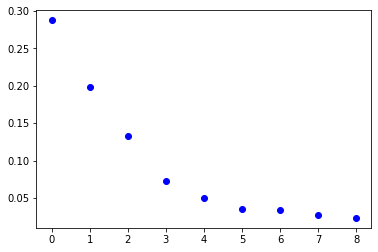

In [80]:
# perform a PCA analysis
pca = PCA(n_components=9, svd_solver='randomized', whiten=True)  
X_train_ = pca.fit_transform(X_train)
X_test_ = pca.transform(X_test)  
    
explained_variance = pca.explained_variance_ratio_

print("explained variance", explained_variance)
page_idx = [0] * len(explained_variance)
for i in range(0,len(explained_variance)):
    page_idx[i] = i

n = plt.plot(page_idx, explained_variance, 'bo') 
plt.show()

In [81]:
# perform random forest prediction
classifier = RandomForestClassifier(max_depth=12) #, random_state=0)  
classifier.fit(X_train_, y_train)

RandomForestClassifier(max_depth=12)

In [82]:
# Predicting the Test set results
y_pred = classifier.predict(X_test_)

y_test1 = np.ravel(y_test)
cm = confusion_matrix(y_test1, y_pred)  
print("Confusion Matrix:")
print(cm)  
print('Accuracy: {}'.format(accuracy_score(y_test1, y_pred)))
print('A Negative prediction is {} to be correct.'.format(cm[0][0]/(cm[0][0]+cm[1][0])))
print('A Positive prediction is {} to be correct.'.format(cm[1][1]/(cm[0][1]+cm[1][1])))

Confusion Matrix:
[[7227 8537]
 [7106 8975]]
Accuracy: 0.5087768880514995
A Negative prediction is 0.5042210283960092 to be correct.
A Positive prediction is 0.512505710370032 to be correct.


In [86]:
pred_trades = trades.loc[trades['open'] >= datetime.today() - pd.DateOffset(7)]
p_indicies = []

predset = None
for sym in pred_trades['symbol'].unique():
    trades_ = pred_trades.loc[pred_trades['symbol']==sym]
    
    p_indicies += list(trades_.index)
    
    trade_samples = bars.loc[bars['symbol']==sym]['open_ts'].searchsorted(trades_['open'])
    feature_data = bars.loc[trade_samples][feat_columns]
    feature_data['reason'] = trades_['reason']

    if predset is None:
        predset = np.array(feature_data)
    else:
        predset = np.vstack((predset, feature_data))
predset = pd.DataFrame(predset).fillna(0)
predset.head()

0      1      2      3      4      5      6      7      8      9   ...  \
0  False   True  False   True  False   True  False   True  False   True  ...   
1  False   True   True   True   True   True   True   True   True   True  ...   
2  False  False  False  False   True  False   True  False   True  False  ...   
3   True  False   True  False  False  False  False  False  False  False  ...   
4   True  False   True  False  False  False  False  False  False  False  ...   

         27        28        29        30        31        32        33  \
0  1.000000 -0.451064  1.000000 -0.721741  1.000000  0.971483  0.000178   
1  0.995282  0.058874  0.995282  0.074292  0.995282  0.999747 -0.000002   
2  0.995261  0.054069  0.995261  0.069797  0.995261  0.999742 -0.000001   
3  1.000000 -0.195608  1.000000 -0.321409  1.000000  0.979388  0.002077   
4  1.000000 -0.193178  1.000000 -0.319407  1.000000  0.979858  0.001614   

         34            35  36  
0  0.000092  6.674867e-05   0  
1 -0.000003 -1.164329e-06   0  
2 -0.000002 -9.820807e-07   0  
3  0.000757  2.755972e-04   0  
4  0.000663  2.463527e-04   0  

[5 rows x 37 columns]

In [87]:
P_test = sc.fit_transform(predset)
#P_test = pca.fit_transform(P_test)

res = classifier.predict(P_test)

In [88]:
longs = pred_trades.loc[ [i for i,r in zip(p_indicies,res) if r != 0] ]
longs.to_csv('algo-trading/tmp/trade_predictions_{}.csv'.format(datetime.now().strftime('%Y-%m-%d_%H%M%S')))

In [83]:
classifier = MLPClassifier(hidden_layer_sizes=[dataset.shape[1]*7, 10], max_iter=900000, alpha=0.00001)

classifier.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=[259, 10], max_iter=900000)

In [84]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

y_test1 = np.ravel(y_test)
cm = confusion_matrix(y_test1, y_pred)  
print("Confusion Matrix:")
print(cm)  
print('Accuracy: {}'.format(accuracy_score(y_test1, y_pred)))
print('A Negative prediction is {} to be correct.'.format(cm[0][0]/(cm[0][0]+cm[1][0])))
print('A Positive prediction is {} to be correct.'.format(cm[1][1]/(cm[0][1]+cm[1][1])))
print('Accuracy for True prediction:')

Confusion Matrix:
[[8582 7182]
 [8376 7705]]
Accuracy: 0.5114460668864814
A Negative prediction is 0.5060738294610213 to be correct.
A Positive prediction is 0.5175656613152415 to be correct.
Accuracy for True prediction:


In [481]:
y_test1, X_test

(array([0, 0, 1, ..., 1, 0, 0]),
 array([[ 1.11547478,  1.137116  ,  1.12561886, ...,  0.186763  ,
          0.28028228,  0.40423899],
        [-0.89647925, -0.87941776, -0.88840018, ...,  0.17665917,
          0.27280852,  0.30451826],
        [-0.89647925, -0.87941776,  1.12561886, ...,  0.10250814,
         -0.15184038, -0.36691048],
        ...,
        [-0.89647925, -0.87941776, -0.88840018, ...,  0.11803628,
          0.0427107 , -0.39449597],
        [ 1.11547478, -0.87941776, -0.88840018, ...,  0.11917671,
          0.02834101, -0.19970441],
        [ 1.11547478,  1.137116  ,  1.12561886, ..., -3.46075963,
         -1.8491362 , -1.09248269]]))

In [28]:
bars.columns

Index(['finnhub_volume_bars_60_index', 'created_at', 'updated_at', 'o', 'c',
       'h', 'l', 'v', 't', 'symbol', 'c_ma_5_flag', 'c_ma_10_flag',
       'c_ma_20_flag', 'c_ma_40_flag', 'c_ma_80_flag', 'c_ma_160_flag',
       'c_ma_320_flag', 'ts', 'c_ma_5', 't_ma_5', 't_ma_5_flag', 'c_ma_10',
       't_ma_10', 't_ma_10_flag', 'c_ma_20', 't_ma_20', 't_ma_20_flag',
       'c_ma_40', 't_ma_40', 't_ma_40_flag', 'c_ma_80', 't_ma_80',
       't_ma_80_flag', 'c_ma_160', 't_ma_160', 't_ma_160_flag', 'c_ma_320',
       't_ma_320', 't_ma_320_flag', 'delta_ts', 'entropy',
       'c_ma_5_flag_dir_flag', 'c_ma_10_flag_dir_flag',
       'c_ma_20_flag_dir_flag', 'c_ma_40_flag_dir_flag',
       'c_ma_80_flag_dir_flag', 'c_ma_160_flag_dir_flag',
       'c_ma_320_flag_dir_flag', 'c_ma_5_dir_flag', 'c_ma_10_dir_flag',
       'c_ma_20_dir_flag', 'c_ma_40_dir_flag', 'c_ma_80_dir_flag',
       'c_ma_160_dir_flag', 'c_ma_320_dir_flag', '10_delta_flag',
       '25_delta_flag', '50_delta_flag', 'open_ts'],
    